<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/neural_network_for_lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = datasets.load_iris().data
target = np.zeros([datasets.load_iris().target.shape[0], 3])
for i in range(datasets.load_iris().target.shape[0]):
  target[i][datasets.load_iris().target[i]] = 1

In [131]:
data = pd.DataFrame(datasets.load_iris().data, columns=list('ABCD'))
data['E'] = datasets.load_iris().target
data_tr = data.sample(n = 100, replace=False)
data_te = data.sample(n = 50, replace=False)
data_tr_data = np.array(data_tr.drop(columns=['E']))
data_tr_label = np.array(data_tr['E'])
data_tr_target = np.zeros([data_tr_label.size, 3])
for i in range(data_tr_label.size):
  data_tr_target[i][data_tr_label[i]] = 1
data_te_data = np.array(data_te.drop(columns=['E']))
data_te_label = np.array(data_te['E'])
data_te_target = np.zeros([data_te_label.size, 3])
for i in range(data_te_label.size):
  data_te_target[i][data_te_label[i]] = 1

In [144]:
class neural_network():
  def __init__(self, input_size, hidden_size, output_size, weight_init=0.1):
    self.w1 = weight_init * np.random.rand(input_size, hidden_size)
    self.b1 = np.zeros(hidden_size)
    self.w2 = weight_init * np.random.rand(hidden_size, output_size)
    self.b2 = np.zeros(output_size)

  def sigmoid(self, x):
    return 1.0 / (1.0 + np.exp(-x))

  def softmax(self, a):
    c = np.max(a)
    e_a = np.exp(a-c)
    sum_e_a = np.sum(e_a)
    return e_a / sum_e_a

  def forward(self, x):
    a1 = np.dot(x, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2
    y = self.softmax(a2)
    return y

  def cross_entropy_error(self, y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

  def cost_function(self, data, target):
    error_list = [self.cross_entropy_error(self.forward(data[i]), target[i]) for i in range(data.shape[0])]
    return np.sum(np.array(error_list) / data.shape[0])
      
  def gradient(self, data, target):
    h = 1e-4
    grad_w1 = np.zeros_like(self.w1)
    grad_w2 = np.zeros_like(self.w2)
    grad_b1 = np.zeros_like(self.b1)
    grad_b2 = np.zeros_like(self.b2)
    for i in range(self.w1.shape[0]):
      for j in range(self.w1.shape[1]):
        w_ij = self.w1[i][j]
        self.w1[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w1[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w1[i][j] = (y_r-y_l) / (2*h)
        self.w1[i][j] = w_ij
    for i in range(self.w2.shape[0]):
      for j in range(self.w2.shape[1]):
        w_ij = self.w2[i][j]
        self.w2[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w2[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w2[i][j] = (y_r-y_l) / (2*h)
        self.w2[i][j] = w_ij
    for i in range(self.b1.size):
      b_i = self.b1[i]
      self.b1[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b1[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b1[i] = (y_r-y_l) / (2*h)
      self.b1[i] = b_i
    for i in range(self.b2.size):
      b_i = self.b2[i]
      self.b2[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b2[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b2[i] = (y_r-y_l) / (2*h)
      self.b2[i] = b_i
    return grad_w1, grad_w2, grad_b1, grad_b2

  def train(self, data, target, learning_rate = 0.01, times = 100):
    error = np.zeros(times)
    for i in range(times):
      grad_w1, grad_w2, grad_b1, grad_b2 = self.gradient(data, target)
      self.w1 -= learning_rate * grad_w1
      self.w2 -= learning_rate * grad_w2
      self.b1 -= learning_rate * grad_b1
      self.b1 -= learning_rate * grad_b1
      error[i] = self.cost_function(data, target)
    return error

  def recognize(self, x):
    return np.argmax(self.forward(x))

In [145]:
nn = neural_network(4, 10, 3)
error = nn.train(data_tr_data, data_tr_target, 0.3, 200)

In [146]:
correct = 0
for i in range(50):
  if data_te_target[i][nn.recognize(data_te_data[i])] == 1:
    correct += 1
correct / 50


0.98

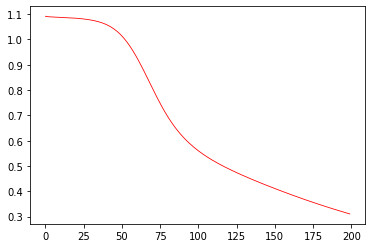

In [155]:
times = np.arange(0, 200, 1)
plt.plot(times, error, 'r', label='GD', linewidth=0.8)

In [ ]:
def relu(x):
  return np.maximum(0, x)

In [ ]:
class neural_network():
  def __init__(self, input_size, hidden_size, output_size, weight_init=0.01):
    self.parameters = {}
    self.parameters['w1'] = weight_init * np.random.rand(input_size, hidden_size)
    self.parameters['b1'] = np.zeros(hidden_size)
    self.parameters['w2'] = weight_init * np.random.rand(hidden_size, output_size)
    self.parameters['b2'] = np.zeros(output_size)

  def recognize(self, x):
    w1,w2 = self.parameters['w1'],self.parameters['w2']
    b1,b2 = self.parameters['b1'],self.parameters['b2']
    x = x /255
    a1 = np.dot(x,w1) + b1
    z = sigmoid(a1)
    a2 = np.dot(z,w2) + b2
    y = a2
    
    return y

  def cost_function(self, x, label):
    y = self.recognize(x)
    print(y)
    d = 1e-7
    cee = -np.log(y[label]+d)

    return cee
  
  def gradient(self, x, label):
    h = 1e-4
    grads = {}
    for key in ('w1','b1','w2','b2'):
      grads[key] = np.zeros(self.parameters[key].size)
      index = 0
      for p in self.parameters[key]:
        p_value = p
        p = p_value+h
        loss_p = self.cost_function(x, label)
        p = p_value-h
        loss_n = self.cost_function(x, label)
        p = p_value
        grads[key][index] = (loss_p-loss_n) / (2*h)
        index += 1
      grads[key].reshape(self.parameters[key].shape)

    return grads

  